### Enviroment

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


os.environ["groq_api_key"]=os.getenv("groq_api_key")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["hf_api_key"] = os.getenv("hf_api_key")

### Retriever

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_ollama.embeddings import OllamaEmbeddings

embd = OllamaEmbeddings(model = "nomic-embed-text:latest")

docs = PyPDFLoader(file_path="FAT_SCADA_AL KUS.pdf")
docs = docs.load()

splitter = RecursiveCharacterTextSplitter(chunk_size = 900, chunk_overlap = 100, separators=["\n# ", "\n## ", "\n### ", "\n\n", "\n", " "])
splitted_docs = splitter.split_documents(docs)

vectorstore=FAISS.from_documents(documents=splitted_docs,embedding=embd)

retriever=vectorstore.as_retriever()

### WebSearch

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

C:\Users\mdamb\AppData\Local\Temp\ipykernel_6468\2239647488.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


### Structure Model for route

In [5]:
from typing import Literal
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "web_search"] = Field(description="Given a user question choose to route it to web search or a vectorstore.",)

model = ChatGroq(model= "llama-3.1-8b-instant")
structured_model_router = model.with_structured_output(RouteQuery)

route_prompt = ChatPromptTemplate.from_messages([("system", "You are an expert at routing user questions with laser precision: use the **vectorstore** if the question is related to the **SCADA FAT Document** (including all 14 annexures: Compliance, CRS, Architecture, Diagrams, Datasheets, FDS, FAT/SAT Procedures, Backup, Calculations, Warranty, Spares, and Deviations); for **ANY other question**, use **web search**."),
                                                 ("human", "{question}"),])

question_router = route_prompt | structured_model_router

### Structure Model for Document

In [21]:
class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

llm = ChatGroq(model= "llama-3.1-8b-instant")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. We only need to catch obvious mismatches.\n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [("system", system),
     ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),])

retrieval_grader = grade_prompt | structured_llm_grader

### Chain to generate 

In [7]:
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

llm = ChatGroq(model= "llama-3.1-8b-instant")

rag_chain = prompt | llm | StrOutputParser()


### Structure Model for Hallucination -> checks the output is based on Fact or not

In [22]:
class GradeHallucinations(BaseModel):
    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

llm = ChatGroq(model= "llama-3.1-8b-instant")
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is addressed / supported by a set of retrieved facts. \n 
            Give a binary score 'yes' or 'no'. 'Yes' means that the answer is addressed / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

### Structure Model for Comparison of user question and Answer

In [23]:
class GradeAnswer(BaseModel):
    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

llm = ChatGroq(model= "llama-3.1-8b-instant")
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves / addresses the question."""
answer_prompt = ChatPromptTemplate.from_messages([("system", system),
                ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),])

answer_grader = answer_prompt | structured_llm_grader

### Structure Model for Rewriting the query

In [10]:
llm = ChatGroq(model= "llama-3.1-8b-instant")

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
re_write_prompt = ChatPromptTemplate.from_messages([("system", system),
        ("human","Here is the initial question: \n\n {question} \n Formulate an improved question."),])

question_rewriter = re_write_prompt | llm | StrOutputParser()

### State

In [11]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

### Nodes

In [ ]:
from langchain_classic.schema import Document

def route_question(state):
    """
    Route question to web search or RAG.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def web_search(state):
    """
    Web search based on the re-phrased question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    
    return {"documents": web_results, "question": question}

def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question} ## the documents which are relevant that document is added to filtered_docs :: and filtered_docs will be sent to another node


def transform_query(state):
    """
    Transform the query to produce a better question.
    Args:
        state (dict): The current graph state
b    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score   

    # Check hallucination
    if grade == "yes":
        print("---DECISION: NO HALLUCINATIONS---")
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION:: FINAL OUTPUT---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION::  CHANGE QUERY---")
            return "not useful"
    else:
        print("---DECISION: HALLUCINATIONS OCCURED:: GENERATE AGAIN---")
        return "not supported"

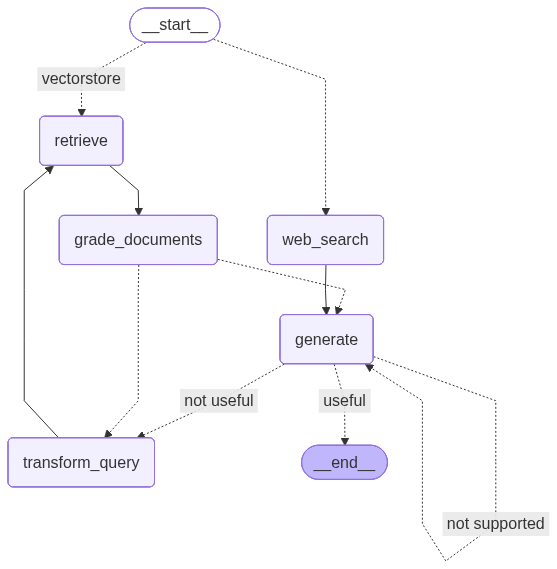

In [40]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image,display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(START,route_question,{"web_search": "web_search","vectorstore": "retrieve",},)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents",decide_to_generate,{"transform_query": "transform_query","generate": "generate",},)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges("generate",grade_generation_v_documents_and_question,{"not supported": "generate","useful": END,"not useful": "transform_query",},)

# Compile
graph = workflow.compile()

flow = graph.get_graph().draw_mermaid_png()
display(Image(flow))

In [45]:
graph.invoke({"question":"Additional requirements"})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: NO HALLUCINATIONS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION:: FINAL OUTPUT---


{'question': 'Additional requirements',
 'generation': 'The additional requirements include complying with local laws, ordinances, regulatory requirements, codes, and standards of Saudi Arabia, including the Essential Cybersecurity Controls – ECC-1: 2018. The Contractor must also comply with all Offtaker requirements. In case of contradictions, the Contractor shall submit the final design criteria to the Owner for approval.',
 'documents': [Document(id='ed74094e-e03f-4bc2-be93-442fabae911f', metadata={'producer': 'PyPDF', 'creator': 'Nitro PDF Pro 14 (14.34.2.0)', 'creationdate': '2025-01-27T15:03:45+05:30', 'moddate': '2025-04-23T12:13:07+05:30', 'source': 'FAT_SCADA_AL KUS.pdf', 'total_pages': 1106, 'page': 42, 'page_label': '43'}, page_content='stringent requirements shall apply. Should there be any difference of opinion with regard to the \ninterpretation of requirements, the Owner shall instruct the vendor as to the requirements and the vendor \nshall, at its own cost, comply with